# Train/fine-tune computer vision (CV) classifiers

In this notebook, we use the annotated images (see, e.g., notebooks `001` and `002`) to train/fine-tune CV classifiers.

In [1]:
# solve issue with autocomplete
%config Completer.use_jedi = False

%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from mapreader import classifier
from mapreader import loadAnnotations
from mapreader import patchTorchDataset

import numpy as np
import torch
from torch import nn
import torchvision
from torchvision import transforms
from torchvision import models

## Read annotations

In [12]:
annotated_images = loadAnnotations()

In [13]:
annotated_images.load("./annotations_one_inch/rail_space_#kasra#.csv", 
                      path2dir="./maps_tutorial/slice_50_50")

* reading: ./annotations_one_inch/rail_space_#kasra#.csv
* #rows: 281
* label column name: label (you can change this later by .set_col_label(new_label) )
* shuffle rows: Yes
* update paths in 'image_id' column by inserting './maps_tutorial/slice_50_50'

------------------------
* Number of annotations: 281

* First few rows:
                                            image_id  label
0  /Users/rwood/MapReader/examples/geospatial/cla...      1
1  /Users/rwood/MapReader/examples/geospatial/cla...      1
2  /Users/rwood/MapReader/examples/geospatial/cla...      1
3  /Users/rwood/MapReader/examples/geospatial/cla...      1
4  /Users/rwood/MapReader/examples/geospatial/cla...      1
...

* Value counts (column: label):
1    226
2     55
Name: label, dtype: int64
------------------------



In [14]:
annotated_images.annotations.columns.tolist()

['image_id', 'label']

In [15]:
print(annotated_images)

------------------------
* Number of annotations: 281

* First few rows:
                                            image_id  label
0  /Users/rwood/MapReader/examples/geospatial/cla...      1
1  /Users/rwood/MapReader/examples/geospatial/cla...      1
2  /Users/rwood/MapReader/examples/geospatial/cla...      1
3  /Users/rwood/MapReader/examples/geospatial/cla...      1
4  /Users/rwood/MapReader/examples/geospatial/cla...      1
...

* Value counts (column: label):
1    226
2     55
Name: label, dtype: int64
------------------------



In [16]:
# We need to shift these labels so that they start from 0:
annotated_images.adjust_labels(shiftby=-1)

--------------------
[INFO] value counts before shift:
1    226
2     55
Name: label, dtype: int64
--------------------
[INFO] value counts after shift:
0    226
1     55
Name: label, dtype: int64
--------------------


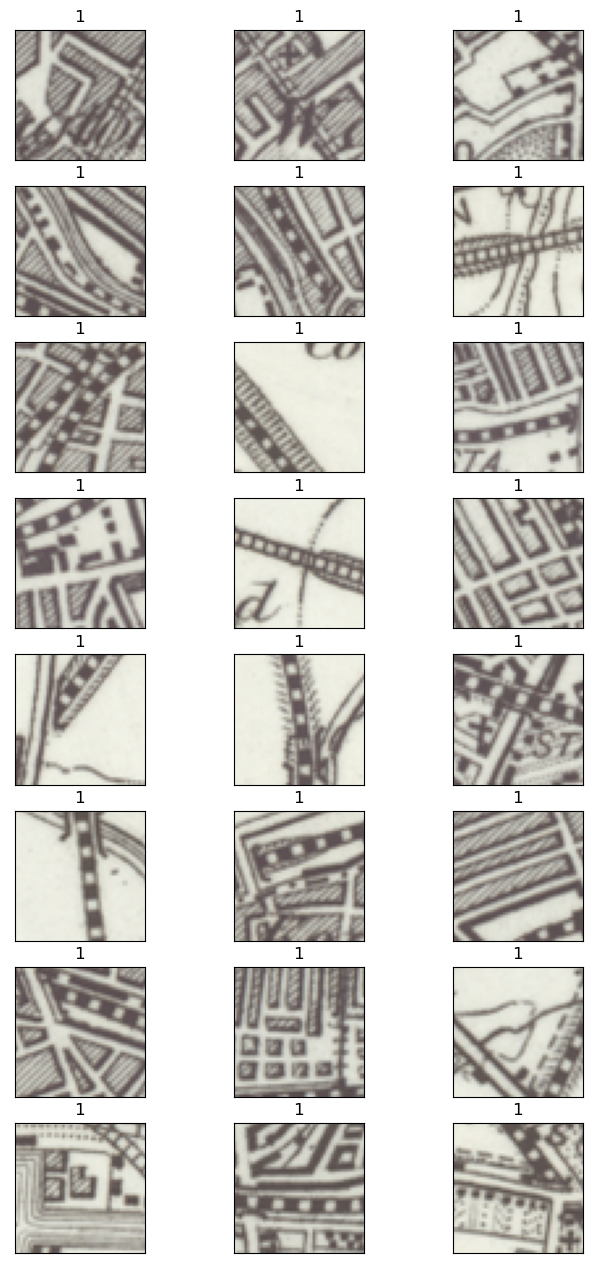

In [20]:
# show sample images for target label (tar_label)
annotated_images.show_image_labels(tar_label=1, num_sample=24)

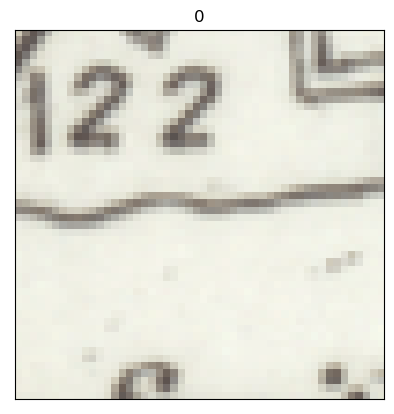

In [23]:
# show an image based on its index 
annotated_images.show_image(indx=31)

### Split annotations into train/val or train/val/test

We use a stratified method for splitting the annotations, that is, each set contains approximately the same percentage of samples of each target label as the original set.

In [24]:
annotated_images.split_annotations(frac_train=0.7, 
                                   frac_val=0.15, 
                                   frac_test=0.15)

---------------------
* Split dataset into:
    Train: 196
    Valid: 42
    Test : 43
---------------------


Dataframes for train, validation and test sets can be accessed via:

```python
annotated_images.train
annotated_images.val
annotated_images.test
```

In [25]:
annotated_images.train["label"].value_counts()

0    158
1     38
Name: label, dtype: int64

In [26]:
annotated_images.val["label"].value_counts()

0    34
1     8
Name: label, dtype: int64

In [27]:
annotated_images.test["label"].value_counts()

0    34
1     9
Name: label, dtype: int64

# Classifier

## Dataset

Define transformations to be applied to images before being used in training or validation/inference.

`patchTorchDataset` has some default transformations. However, it is possible to define your own transformations and pass them to `patchTorchDataset`:

In [28]:
# ------------------
# --- Transformation
# ------------------ 

# FOR INCEPTION
#resize2 = 299
# otherwise:
resize2 = 224

# mean and standard deviations of pixel intensities in 
# all the patches in 6", second edition maps
normalize_mean = 1 - np.array([0.82860442, 0.82515008, 0.77019864])
normalize_std = 1 - np.array([0.1025585, 0.10527616, 0.10039222])
# other options:
# normalize_mean = [0.485, 0.456, 0.406]
# normalize_std = [0.229, 0.224, 0.225]

data_transforms = {
    'train': transforms.Compose(
        [transforms.Resize(resize2),
         transforms.RandomApply([
             transforms.RandomHorizontalFlip(p=0.5),
             transforms.RandomVerticalFlip(p=0.5),
             ], p=0.5),
         transforms.RandomApply([
             transforms.GaussianBlur(21, sigma=(0.5, 5.0)),
             ], p=0.25),
         transforms.RandomApply([
             #transforms.RandomPerspective(distortion_scale=0.5, p=0.5),
             transforms.Resize((50, 50)),
             ], p=0.25),
#          transforms.RandomApply([
#              transforms.RandomAffine(180, translate=None, scale=None, shear=20),
#              ], p=0.25),
         transforms.Resize(resize2),
        transforms.ToTensor(),
        transforms.Normalize(normalize_mean, normalize_std)
        ]),
    'val': transforms.Compose(
        [transforms.Resize(resize2),
        transforms.ToTensor(),
        transforms.Normalize(normalize_mean, normalize_std)
        ]),
}


Now, we can use these transformations to instantiate `patchTorchDataset`:

In [29]:
train_dataset = patchTorchDataset(annotated_images.train, 
                                  transform=data_transforms["train"])
valid_dataset = patchTorchDataset(annotated_images.val,   
                                  transform=data_transforms["val"])
test_dataset  = patchTorchDataset(annotated_images.test,  
                                  transform=data_transforms["val"])

## Sampler

In [30]:
# -----------
# --- Sampler
# -----------
# We define a sampler as we have a highly imbalanced dataset
label_counts_dict = annotated_images.train["label"].value_counts().to_dict()

class_sample_count = []
for i in range(0, len(label_counts_dict)):
    class_sample_count.append(label_counts_dict[i])
    
weights = 1. / (torch.Tensor(class_sample_count)/1.)
weights = weights.double()
print(f"Weights: {weights}")

train_sampler = torch.utils.data.sampler.WeightedRandomSampler(
    weights[train_dataset.patchframe["label"].to_list()], 
    num_samples=len(train_dataset.patchframe))

valid_sampler = torch.utils.data.sampler.WeightedRandomSampler(
    weights[valid_dataset.patchframe["label"].to_list()], 
    num_samples=len(valid_dataset.patchframe))


Weights: tensor([0.0063, 0.0263], dtype=torch.float64)


## Dataloader

In [31]:
myclassifier = classifier(device="default")
# myclassifier.load("./checkpoint_12.pkl")

[INFO] Device is set to cpu


In [32]:
batch_size = 8

# Add training dataset
myclassifier.add2dataloader(train_dataset, 
                            set_name="train", 
                            batch_size=batch_size, 
                            # shuffle can be False as annotations have already been shuffled
                            shuffle=False,
                            num_workers=0,
                            sampler=train_sampler
                           )

# Add validation dataset
myclassifier.add2dataloader(valid_dataset, 
                            set_name="val", 
                            batch_size=batch_size, 
                            shuffle=False, 
                            num_workers=0,
                            #sampler=valid_sampler
                           )

[INFO] added 'train' dataloader with 196 elements.
[INFO] added 'val' dataloader with 42 elements.


In [33]:
myclassifier.print_classes_dl()

[INFO] labels:      [0, 1]


In [34]:
# set class names for plots
class_names = {0: "No", 
               1: "rail space"}
myclassifier.set_classnames(class_names)

In [35]:
myclassifier.print_classes_dl()

[INFO] labels:      [0, 1]
[INFO] class-names: {0: 'No', 1: 'rail space'}


In [36]:
myclassifier.batch_info()

[INFO] dataset: train
#samples:    196
#batch size: 8
#batches:    25


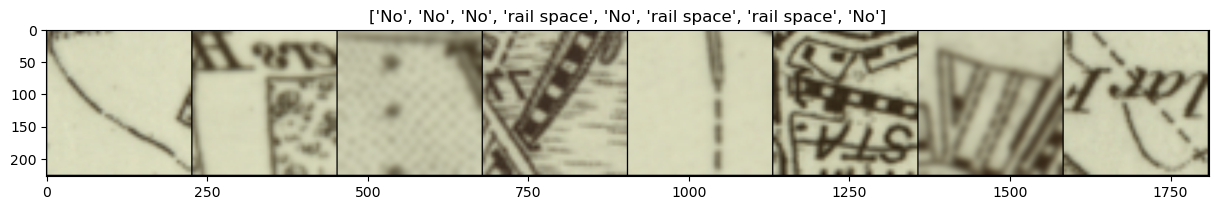

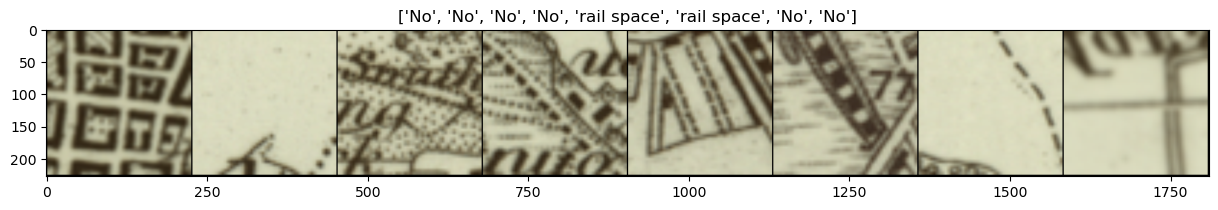

In [38]:
for bn in range(1, 3):
    myclassifier.show_sample(set_name="train", 
                             batch_number=bn, 
                             print_batch_info=False)

## Load a (pretrained) PyTorch model and add it to `classifier`

Two methods to add a (pretrained) PyTorch model:
1. Define a model using `from torchvision import models`
2. Use `.initialize_model` method

### Method 1: Define a model using `from torchvision import models`

In [39]:
# # Choose a model from the supported PyTorch models
# model_ft = models.resnet18(pretrained=True)

# # Add FC based on the number of classes
# num_ftrs = model_ft.fc.in_features
# model_ft.fc = nn.Linear(num_ftrs, myclassifier.num_classes)

# # Add the model to myclassifier
# myclassifier.add_model(model_ft)

In [40]:
# myclassifier.model_summary()

### Method 2: use `.initialize_model`

In [41]:
myclassifier.del_model()

In [42]:
myclassifier.initialize_model("resnet18", 
                              pretrained=True, 
                              last_layer_num_classes="default",
                              add_model=True)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /Users/rwood/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100.0%


[INFO] labels:      [0, 1]
[INFO] class-names: {0: 'No', 1: 'rail space'}


In [43]:
myclassifier.model_summary(only_trainable=False)

------------------------------------------------------------------------------------------
|                                  modules |           parameters |                  dim
------------------------------------------------------------------------------------------
|                             conv1.weight |                 9408 |        [64, 3, 7, 7] |
|                               bn1.weight |                   64 |                 [64] |
|                                 bn1.bias |                   64 |                 [64] |
|                    layer1.0.conv1.weight |                36864 |       [64, 64, 3, 3] |
|                      layer1.0.bn1.weight |                   64 |                 [64] |
|                        layer1.0.bn1.bias |                   64 |                 [64] |
|                    layer1.0.conv2.weight |                36864 |       [64, 64, 3, 3] |
|                      layer1.0.bn2.weight |                   64 |                 [64] |
|

## (Un)freeze layers in the neural network architecture

In [ ]:
# myclassifier.freeze_layers(["conv1.weight", "bn1.weight", "bn1.bias", "layer1*", "layer2*", "layer3*"])
# myclassifier.model_summary(only_trainable=False)

In [ ]:
# myclassifier.unfreeze_layers(["layer3*"])
# myclassifier.model_summary(only_trainable=False)

In [ ]:
# myclassifier.only_keep_layers(["fc.weight", "fc.bias"])
# myclassifier.model_summary(only_trainable=True)

## Define optimizer, scheduler and criterion

We can either use one learning rate for all the layers in the neural network or define layerwise learning rates, that is, the learning rate of each layer is different. This is normally used in fine-tuning pretrained models in which a smaller learning rate is assigned to the first layers.

`MapReader` has a `.layerwise_lr` method to define layerwise learning rates. By default, `MapReader` uses a linear function to distribute the learning rates (using `min_lr` for the first layer and `max_lr` for the last layer). The linear function can be changed using `ltype="geomspace"` argument.

In [44]:
list2optim = myclassifier.layerwise_lr(min_lr=1e-4, max_lr=1e-3)
# #list2optim = myclassifier.layerwise_lr(min_lr=1e-4, max_lr=1e-3, ltype="geomspace")

In [45]:
optim_param_dict = {
    "lr": 1e-3,
    "betas": (0.9, 0.999), 
    "eps": 1e-08, 
    "weight_decay": 0, 
    "amsgrad": False
}

# --- if list2optim is defined, e.g., by using `.layerwise_lr` method (see the previous cell):
myclassifier.initialize_optimizer(optim_type="adam", 
                                  params2optim=list2optim,
                                  optim_param_dict=optim_param_dict,
                                  add_optim=True)

# --- otherwise:
# myclassifier.initialize_optimizer(optim_type="adam", 
#                                   optim_param_dict=optim_param_dict,
#                                   add_optim=True)

Other optimizers can also be used in the above cell, e.g.:

```python
optim_param_dict = {
    "lr": 1e-3, 
    "momentum": 0, 
    "dampening": 0, 
    "weight_decay": 0, 
    "nesterov": False
}

myclassifier.initialize_optimizer(optim_type="sgd", 
                                  optim_param_dict=optim_param_dict,
                                  add_optim=True)
```

In [46]:
scheduler_param_dict = {
    "step_size": 10, 
    "gamma": 0.1, 
    "last_epoch": -1, 
    "verbose": False
}

myclassifier.initialize_scheduler(scheduler_type="steplr",
                                  scheduler_param_dict=scheduler_param_dict,
                                  add_scheduler=True)

Other schedulers can also be used in the above cell, e.g.:

```python
scheduler_param_dict = {
    "max_lr": 1e-2, 
    "steps_per_epoch": len(myclassifier.dataloader["train"]), 
    "epochs": 5
}

myclassifier.initialize_scheduler(scheduler_type="OneCycleLR",
                                  scheduler_param_dict=scheduler_param_dict,
                                  add_scheduler=True)
```

In [47]:
# Add criterion
criterion = nn.CrossEntropyLoss()

myclassifier.add_criterion(criterion)

## Train/fine-tune a model

In [48]:
myclassifier.train_component_summary()

* Optimizer:
Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: False
    initial_lr: 0.0001
    lr: 0.0001
    maximize: False
    weight_decay: 0

Parameter Group 1
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: False
    initial_lr: 0.00011475409836065574
    lr: 0.00011475409836065574
    maximize: False
    weight_decay: 0

Parameter Group 2
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: False
    initial_lr: 0.0001295081967213115
    lr: 0.0001295081967213115
    maximize: False
    weight_decay: 0

Parameter Group 3
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: False
    initial_lr: 0.00014426229508196722
    lr

**Note:** it is possible to interrupt a training (using Kernel/Interrupt in Jupyter Notebook or ctrl+C). 

In [49]:
myclassifier.train(num_epochs=5, 
                   save_model_dir="./models_tutorial", 
                   tensorboard_path="tboard_tutorial", 
                   verbosity_level=0,
                   tmp_file_save_freq=2,
                   remove_after_load=False,
                   print_info_batch_freq=5)

2023-01-25 13:44:13 JY5FK6W3K5 [INFO] train    -- 1/5 --       8/196 (  4.1%) -- Loss: 0.753
2023-01-25 13:44:14 JY5FK6W3K5 [INFO] train    -- 1/5 --      48/196 ( 24.5%) -- Loss: 2.159
2023-01-25 13:44:16 JY5FK6W3K5 [INFO] train    -- 1/5 --      88/196 ( 44.9%) -- Loss: 0.699
2023-01-25 13:44:17 JY5FK6W3K5 [INFO] train    -- 1/5 --     128/196 ( 65.3%) -- Loss: 0.410
2023-01-25 13:44:19 JY5FK6W3K5 [INFO] train    -- 1/5 --     168/196 ( 85.7%) -- Loss: 1.906
2023-01-25 13:44:20 JY5FK6W3K5 [INFO] train    -- 1/5 -- Loss: 0.927; F_macro: 69.34; R_macro: 69.52
2023-01-25 13:44:20 JY5FK6W3K5 [INFO] val      -- 1/5 --        8/42 ( 19.0%) -- Loss: 3.424
2023-01-25 13:44:21 JY5FK6W3K5 [INFO] val      -- 1/5 --       42/42 (100.0%) -- Loss: 5.691
2023-01-25 13:44:21 JY5FK6W3K5 [INFO] val      -- 1/5 -- Loss: 3.122; F_macro: 57.58; R_macro: 75.00

2023-01-25 13:44:21 JY5FK6W3K5 [INFO] train    -- 2/5 --       8/196 (  4.1%) -- Loss: 0.422
2023-01-25 13:44:22 JY5FK6W3K5 [INFO] train    -- 2/5

### Plot results

In [50]:
list(myclassifier.metrics.keys())

['epoch_loss_train',
 'epoch_prec_micro_train',
 'epoch_recall_micro_train',
 'epoch_fscore_micro_train',
 'epoch_supp_micro_train',
 'epoch_rocauc_micro_train',
 'epoch_prec_macro_train',
 'epoch_recall_macro_train',
 'epoch_fscore_macro_train',
 'epoch_supp_macro_train',
 'epoch_rocauc_macro_train',
 'epoch_prec_weighted_train',
 'epoch_recall_weighted_train',
 'epoch_fscore_weighted_train',
 'epoch_supp_weighted_train',
 'epoch_rocauc_weighted_train',
 'epoch_prec_0_train',
 'epoch_recall_0_train',
 'epoch_fscore_0_train',
 'epoch_supp_0_train',
 'epoch_prec_1_train',
 'epoch_recall_1_train',
 'epoch_fscore_1_train',
 'epoch_supp_1_train',
 'epoch_loss_val',
 'epoch_prec_micro_val',
 'epoch_recall_micro_val',
 'epoch_fscore_micro_val',
 'epoch_supp_micro_val',
 'epoch_rocauc_micro_val',
 'epoch_prec_macro_val',
 'epoch_recall_macro_val',
 'epoch_fscore_macro_val',
 'epoch_supp_macro_val',
 'epoch_rocauc_macro_val',
 'epoch_prec_weighted_val',
 'epoch_recall_weighted_val',
 'epoch_fs

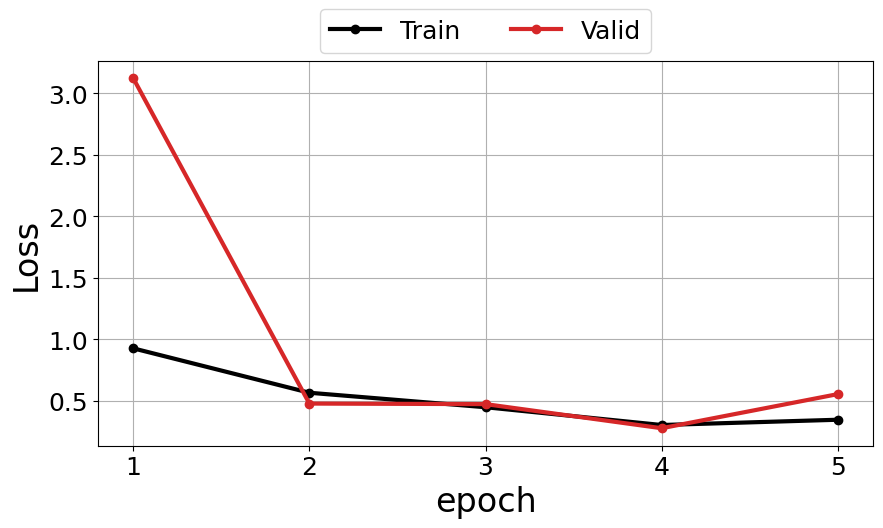

In [51]:
myclassifier.plot_metric(y_axis=["epoch_loss_train", "epoch_loss_val"],
                         y_label="Loss",
                         legends=["Train", "Valid"],
                         colors=["k", "tab:red"])

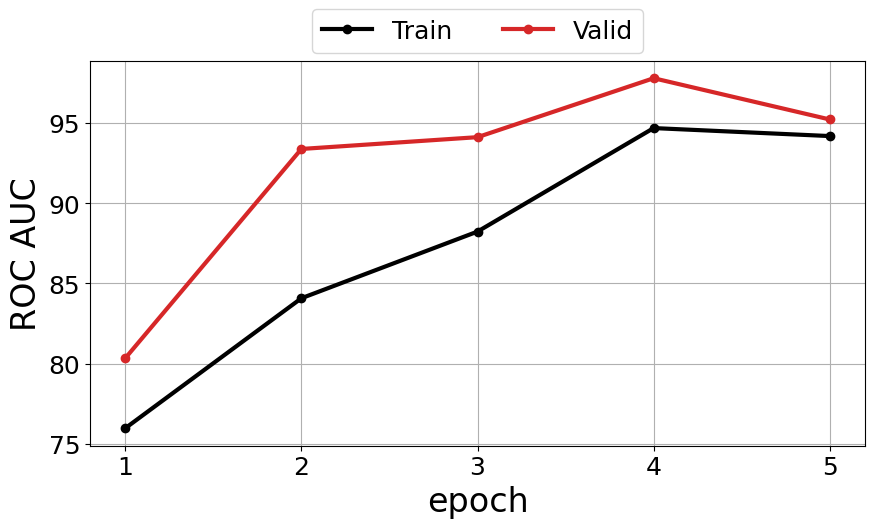

In [52]:
myclassifier.plot_metric(y_axis=["epoch_rocauc_macro_train", "epoch_rocauc_macro_val"],
                         y_label="ROC AUC",
                         legends=["Train", "Valid"],
                         colors=["k", "tab:red"])

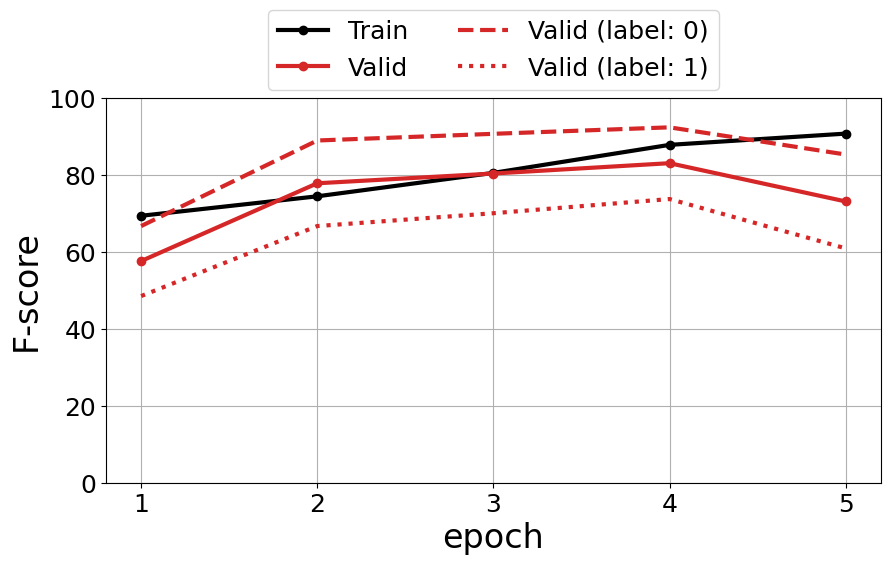

In [53]:
myclassifier.plot_metric(y_axis=["epoch_fscore_macro_train", 
                                 "epoch_fscore_macro_val", 
                                 "epoch_fscore_0_val", 
                                 "epoch_fscore_1_val"],
                         y_label="F-score",
                         legends=["Train", 
                                  "Valid", 
                                  "Valid (label: 0)",
                                  "Valid (label: 1)",],
                         colors=["k", "tab:red", "tab:red", "tab:red"],
                         styles=["-", "-", "--", ":"],
                         markers=["o", "o", "", ""],
                         plt_yrange=[0, 100])

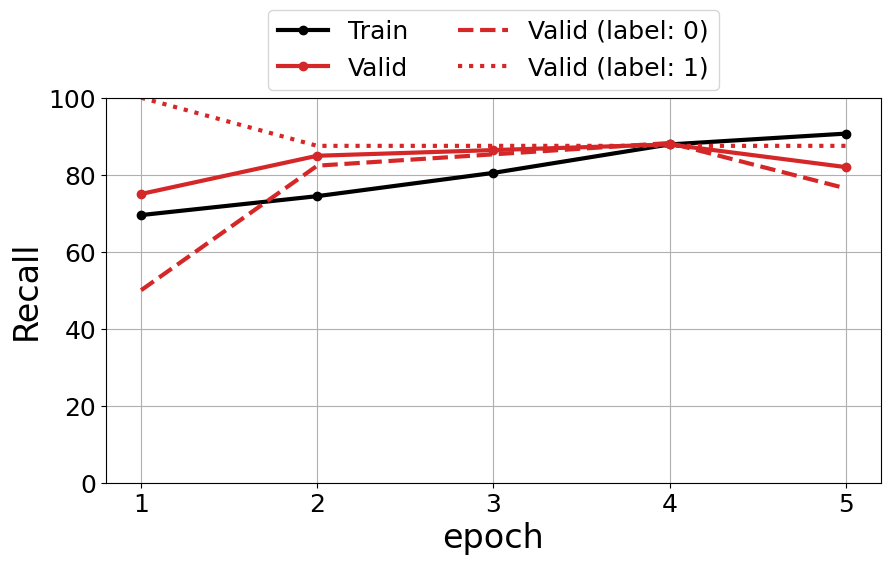

In [54]:
myclassifier.plot_metric(y_axis=["epoch_recall_macro_train", 
                                 "epoch_recall_macro_val", 
                                 "epoch_recall_0_val", 
                                 "epoch_recall_1_val"],
                         y_label="Recall",
                         legends=["Train", 
                                  "Valid", 
                                  "Valid (label: 0)",
                                  "Valid (label: 1)",],
                         colors=["k", "tab:red", "tab:red", "tab:red"],
                         styles=["-", "-", "--", ":"],
                         markers=["o", "o", "", ""],
                         plt_yrange=[0, 100])

## Model inference on test set

Refer to the next notebook for details on model inference. Here, we use the test dataset (defined above) and run the trained model on that set.

In [55]:
# Add test dataset
myclassifier.add2dataloader(test_dataset, 
                            set_name="test", 
                            batch_size=batch_size, 
                            shuffle=False, 
                            num_workers=0)

[INFO] added 'test' dataloader with 43 elements.


In [56]:
# model inference
myclassifier.inference(set_name="test")

2023-01-25 13:45:40 JY5FK6W3K5 [INFO] test     -- 6/6 --        8/43 ( 18.6%) -- 
2023-01-25 13:45:41 JY5FK6W3K5 [INFO] test     -- 6/6 --       43/43 (100.0%) -- 
Total time: 0m 1s


In [57]:
# Calculate metrics using inference outputs
myclassifier.calculate_add_metrics(myclassifier.orig_label, 
                                   myclassifier.pred_label,
                                   myclassifier.pred_conf,
                                   "test")

In [58]:
# list of calculated metrics (for test set):
[k for k in myclassifier.metrics if "test" in k]

['epoch_prec_micro_test',
 'epoch_recall_micro_test',
 'epoch_fscore_micro_test',
 'epoch_supp_micro_test',
 'epoch_rocauc_micro_test',
 'epoch_prec_macro_test',
 'epoch_recall_macro_test',
 'epoch_fscore_macro_test',
 'epoch_supp_macro_test',
 'epoch_rocauc_macro_test',
 'epoch_prec_weighted_test',
 'epoch_recall_weighted_test',
 'epoch_fscore_weighted_test',
 'epoch_supp_weighted_test',
 'epoch_rocauc_weighted_test',
 'epoch_prec_0_test',
 'epoch_recall_0_test',
 'epoch_fscore_0_test',
 'epoch_supp_0_test',
 'epoch_prec_1_test',
 'epoch_recall_1_test',
 'epoch_fscore_1_test',
 'epoch_supp_1_test']

In [59]:
print(myclassifier.metrics["epoch_fscore_micro_test"])
print(myclassifier.metrics["epoch_rocauc_weighted_test"])

[90.69767441860465]
[99.34640522875817]


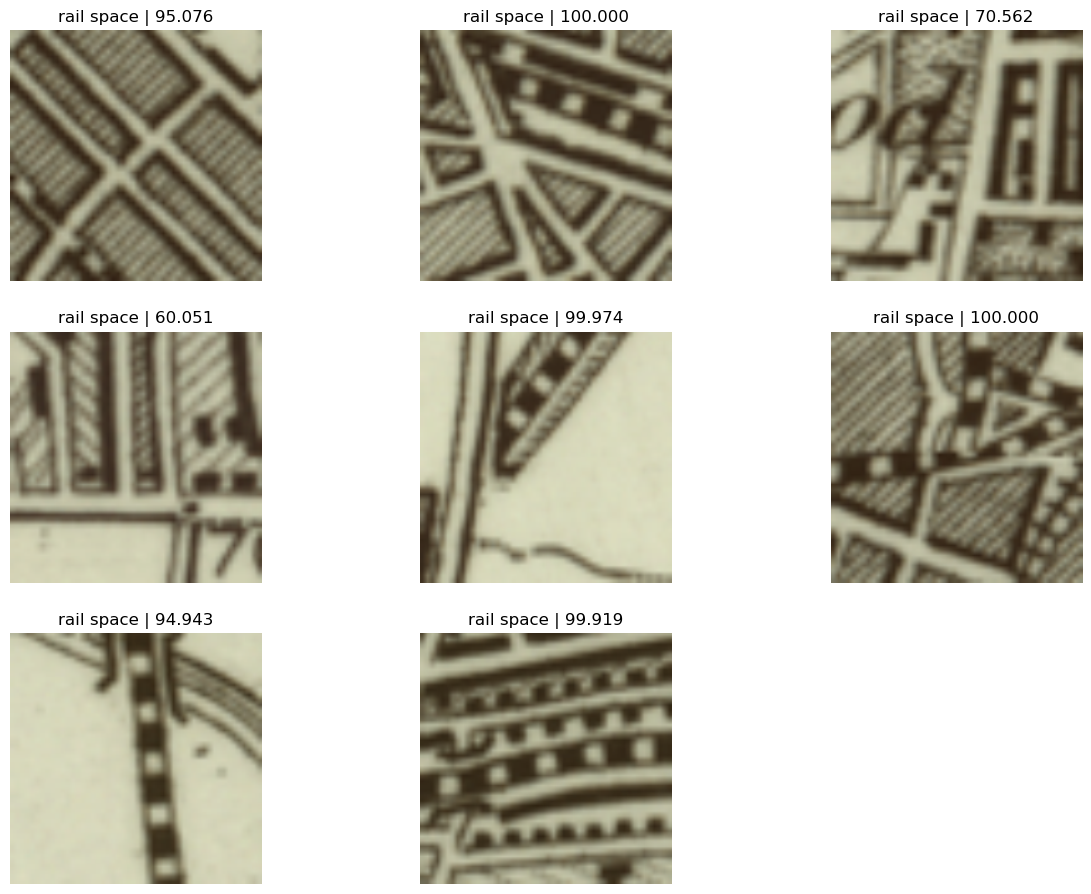

In [60]:
myclassifier.inference_sample_results(num_samples=8, 
                                      class_index=1, 
                                      set_name="test",
                                      min_conf=50,
                                      max_conf=None)